# DATA586 Group12: Text Meets Vision: A Deep Dive into CLIP Performance

Yuzhu Han, Skylar Shao, Mingyue Zhao

In [15]:
import os
import clip
import open_clip

import json
import torch
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

In [ ]:
## if running the notebook in google colab
#from google.colab import drive
#drive.mount('/content/drive')

#import sys
#sys.path.append('/content/drive/MyDrive/DATA586_Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Download

For our project, two datasets require downloading from the following links:

- **ImageNet-Mini**: 
    - dataset: https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000
    - caption: https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
- **Coco**: 
    - image: http://images.cocodataset.org/zips/val2017.zip
    - caption: http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Image-to-Text Classification

### CLIP function

In [12]:
def evaluate_clip(dataset_name, model_name="ViT-B/32", prompt_template="a photo of a {}", batch_size=64):
    """
    Evaluate OpenAI CLIP on a supported torchvision dataset.

    Parameters:
        dataset_name (str): one of ["CIFAR100", "Food101", "EuroSAT"]
        model_name (str): CLIP model name, e.g., "ViT-B/32", "RN50", "ViT-L/14"
        prompt_template (str): Prompt template to apply to class labels
        batch_size (int): Batch size for evaluation
    """
    # Load CLIP model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load(model_name, device=device)

    # Load dataset
    dataset_name = dataset_name.lower()
    if dataset_name == "cifar100":
        dataset = datasets.CIFAR100(root="~/.cache", train=False, download=True, transform=preprocess)
    elif dataset_name == "food101":
        dataset = datasets.Food101(root="~/.cache", split="test", download=True, transform=preprocess)
    elif dataset_name == "eurosat":
        dataset = datasets.EuroSAT(root="~/.cache", download=True, transform=preprocess)
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    classnames = dataset.classes

    # Generate prompts and encode text
    prompts = [prompt_template.format(label.replace("_", " ")) for label in classnames]
    text_inputs = torch.cat([clip.tokenize(p) for p in prompts]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Evaluation loop
    top1, top5, total = 0, 0, 0
    for images, labels in tqdm(dataloader, desc=f"Evaluating {model_name} on {dataset_name}"):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            similarity = image_features @ text_features.T
            top1_preds = similarity.argmax(dim=1)
            top5_preds = similarity.topk(5, dim=1).indices

        top1 += (top1_preds == labels).sum().item()
        top5 += (top5_preds == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

    # Accuracy
    top1_acc = top1 / total * 100
    top5_acc = top5 / total * 100
    print(f"\nCLIP Zero-Shot Evaluation on {dataset_name.upper()} ({model_name}):")
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")
    return top1_acc, top5_acc

### CLIP + Linear Probe function

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)
def build_dataloader(dataset_name, preprocess, batch_size=64):
    """Load dataset with the corresponding preprocess."""
    transform = preprocess
    
    if dataset_name == "cifar100":
        dataset = datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)
    elif dataset_name == "food101":
        dataset = datasets.Food101(root="./data", split="test", download=True, transform=transform)
    elif dataset_name == "eurosat":
        dataset = datasets.EuroSAT(root="./data", download=True, transform=transform)
    else:
        data_root = f"./data/{dataset_name}"
        dataset = datasets.ImageFolder(root=os.path.join(data_root, "val"), transform=transform)
    
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return loader, dataset.classes



def evaluate_linear_probe(loader, model_loaded):
    """Evaluate linear probe using logistic regression with given model."""
    X, y = [], []
    for images, labels in tqdm(loader):
        images = images.to(device)
        with torch.no_grad():
            features = model_loaded.encode_image(images)
            X.append(features.cpu())
            y.append(labels)

    X = torch.cat(X).numpy()
    y = torch.cat(y).numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = LogisticRegression(max_iter=1000, C=1.0)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred) * 100
    test_acc = accuracy_score(y_test, y_test_pred) * 100

    print(f"[Linear Probe] Train Accuracy: {train_acc:.2f}%")
    print(f"[Linear Probe] Test Accuracy:  {test_acc:.2f}%")

    return train_acc, test_acc

def evaluate_dataset(dataset_name, method="linear", model_name="ViT-B/32"):
    model_loaded, preprocess = clip.load(model_name, device=device)
    loader, classnames = build_dataloader(dataset_name, preprocess)
    
    if method == "linear":
        return evaluate_linear_probe(loader, model_loaded)
    else:
        raise ValueError("Only 'linear' method is supported.")

### OpenCIP function

In [ ]:
def evaluate_openclip(dataset_name, model_name="ViT-B-32", pretrained="laion2b_s34b_b79k",
                      prompt_template="a photo of a {}", batch_size=64):
    """
    Evaluate OpenCLIP model on built-in torchvision datasets (CIFAR100, Food101, EuroSAT).

    Parameters:
        dataset_name (str): one of ["CIFAR100", "Food101", "EuroSAT"]
        model_name (str): OpenCLIP model name, e.g. "ViT-B-32", "ViT-L-14", "ViT-H-14"
        pretrained (str): name of pretrained checkpoint, e.g. "laion2b_s34b_b79k"
        prompt_template (str): prompt template for labels, e.g., "a photo of a {}"
        batch_size (int): batch size for evaluation
    """
    # Load OpenCLIP model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, _, preprocess = open_clip.create_model_and_transforms(
        model_name=model_name,
        pretrained=pretrained,
        device=device
    )
    tokenizer = open_clip.get_tokenizer(model_name)

    # Load dataset
    dataset_name = dataset_name.lower()
    if dataset_name == "cifar100":
        dataset = datasets.CIFAR100(root="~/.cache", train=False, download=True, transform=preprocess)
    elif dataset_name == "food101":
        dataset = datasets.Food101(root="~/.cache", split="test", download=True, transform=preprocess)
    elif dataset_name == "eurosat":
        dataset = datasets.EuroSAT(root="~/.cache", download=True, transform=preprocess)
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    classnames = dataset.classes

    # Generate prompts and encode text
    prompts = [prompt_template.format(label.replace("_", " ")) for label in classnames]
    text_inputs = tokenizer(prompts).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Evaluation loop
    top1, top5, total = 0, 0, 0
    for images, labels in tqdm(dataloader, desc=f"Evaluating {model_name} on {dataset_name}"):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            similarity = image_features @ text_features.T
            top1_preds = similarity.argmax(dim=1)
            top5_preds = similarity.topk(5, dim=1).indices

        top1 += (top1_preds == labels).sum().item()
        top5 += (top5_preds == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

    # Accuracy
    top1_acc = top1 / total * 100
    top5_acc = top5 / total * 100
    print(f"\nOpenCLIP Zero-Shot Evaluation on {dataset_name.upper()} ({model_name}):")
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")
    return top1_acc, top5_acc

## Zero-shot CLIP & OpenCLIP

## CIFAR100

### CLIP

#### ViT-B/32

In [ ]:
evaluate_clip("CIFAR100", "ViT-B/32")

Evaluating ViT-B/32 on cifar100: 100%|██████████| 157/157 [00:17<00:00,  9.05it/s]


CLIP Zero-Shot Evaluation on CIFAR100 (ViT-B/32):
Top-1 Accuracy: 64.18%
Top-5 Accuracy: 88.15%


(64.18, 88.14999999999999)

#### ViT-B/16

In [ ]:
evaluate_clip("CIFAR100", "ViT-B/16")

Evaluating ViT-B/16 on cifar100: 100%|██████████| 157/157 [00:20<00:00,  7.74it/s]


CLIP Zero-Shot Evaluation on CIFAR100 (ViT-B/16):
Top-1 Accuracy: 68.04%
Top-5 Accuracy: 89.14%


(68.04, 89.14)

#### Resnet50

In [ ]:
evaluate_clip("CIFAR100", "RN50")

Evaluating RN50 on cifar100: 100%|██████████| 157/157 [00:18<00:00,  8.27it/s]


CLIP Zero-Shot Evaluation on CIFAR100 (RN50):
Top-1 Accuracy: 40.62%
Top-5 Accuracy: 72.30%


(40.62, 72.3)

### OpenCLIP

#### ViT-B-32

In [ ]:
evaluate_openclip("CIFAR100", "ViT-B-32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Evaluating ViT-B-32 on cifar100: 100%|██████████| 157/157 [00:21<00:00,  7.19it/s]


OpenCLIP Zero-Shot Evaluation on CIFAR100 (ViT-B-32):
Top-1 Accuracy: 75.89%
Top-5 Accuracy: 93.86%


(75.89, 93.86)

#### ViT-B-16

In [ ]:
evaluate_openclip("CIFAR100", "ViT-B-16", pretrained="laion400m_e32")

Evaluating ViT-B-16 on cifar100: 100%|██████████| 157/157 [00:37<00:00,  4.24it/s]


OpenCLIP Zero-Shot Evaluation on CIFAR100 (ViT-B-16):
Top-1 Accuracy: 71.61%
Top-5 Accuracy: 92.47%


(71.61, 92.47)

#### ViT-L-14

In [ ]:
evaluate_openclip("CIFAR100", "ViT-L-14", pretrained="laion2b_s32b_b82k")

open_clip_pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Evaluating ViT-L-14 on cifar100: 100%|██████████| 157/157 [01:50<00:00,  1.42it/s]



OpenCLIP Zero-Shot Evaluation on CIFAR100 (ViT-L-14):
Top-1 Accuracy: 82.39%
Top-5 Accuracy: 96.47%


(82.39, 96.47)

#### ConvNeXt-Base

In [ ]:
evaluate_openclip("CIFAR100", "convnext_base", pretrained="laion400m_s13b_b51k")

open_clip_pytorch_model.bin:   0%|          | 0.00/606M [00:00<?, ?B/s]

Evaluating convnext_base on cifar100: 100%|██████████| 157/157 [00:37<00:00,  4.16it/s]


OpenCLIP Zero-Shot Evaluation on CIFAR100 (convnext_base):
Top-1 Accuracy: 46.50%
Top-5 Accuracy: 73.79%


(46.5, 73.79)

## EuroSAT

### CLIP

#### ViT-B/32

In [ ]:
evaluate_clip("EuroSAT", "ViT-B/32")

Evaluating ViT-B/32 on eurosat: 100%|██████████| 422/422 [00:52<00:00,  8.02it/s]


CLIP Zero-Shot Evaluation on EUROSAT (ViT-B/32):
Top-1 Accuracy: 32.18%
Top-5 Accuracy: 82.87%


(32.181481481481484, 82.87037037037037)

#### ViT-B/16

In [ ]:
evaluate_clip("EuroSAT", "ViT-B/16")

Evaluating ViT-B/16 on eurosat: 100%|██████████| 422/422 [01:00<00:00,  6.92it/s]


CLIP Zero-Shot Evaluation on EUROSAT (ViT-B/16):
Top-1 Accuracy: 35.80%
Top-5 Accuracy: 80.89%


(35.8, 80.89259259259259)

#### Resnet50

In [ ]:
evaluate_clip("EuroSAT", "RN50")

Evaluating RN50 on eurosat: 100%|██████████| 422/422 [00:57<00:00,  7.34it/s]


CLIP Zero-Shot Evaluation on EUROSAT (RN50):
Top-1 Accuracy: 17.75%
Top-5 Accuracy: 76.40%


(17.751851851851853, 76.4)

### OpenCLIP

#### ViT-B-32

In [ ]:
evaluate_openclip("EuroSAT", "ViT-B-32")

Evaluating ViT-B-32 on eurosat: 100%|██████████| 422/422 [01:08<00:00,  6.19it/s]


OpenCLIP Zero-Shot Evaluation on EUROSAT (ViT-B-32):
Top-1 Accuracy: 42.24%
Top-5 Accuracy: 90.03%


(42.24074074074074, 90.02592592592593)

#### ViT-B-16

In [ ]:
evaluate_openclip("EuroSAT", "ViT-B-16", pretrained="laion400m_e32")

Evaluating ViT-B-16 on eurosat: 100%|██████████| 422/422 [01:45<00:00,  4.01it/s]


OpenCLIP Zero-Shot Evaluation on EUROSAT (ViT-B-16):
Top-1 Accuracy: 32.12%
Top-5 Accuracy: 83.49%


(32.11851851851852, 83.4925925925926)

#### ViT-L-14

In [ ]:
evaluate_openclip("EuroSAT", "ViT-L-14", pretrained="laion2b_s32b_b82k")

Evaluating ViT-L-14 on eurosat: 100%|██████████| 422/422 [05:05<00:00,  1.38it/s]


OpenCLIP Zero-Shot Evaluation on EUROSAT (ViT-L-14):
Top-1 Accuracy: 12.25%
Top-5 Accuracy: 88.29%


(12.248148148148148, 88.28888888888888)

#### ConvNeXt-Base

In [ ]:
evaluate_openclip("EuroSAT", "convnext_base", pretrained="laion400m_s13b_b51k")

Evaluating convnext_base on eurosat: 100%|██████████| 422/422 [01:49<00:00,  3.86it/s]


OpenCLIP Zero-Shot Evaluation on EUROSAT (convnext_base):
Top-1 Accuracy: 26.53%
Top-5 Accuracy: 74.33%


(26.529629629629632, 74.32592592592593)

## FOOD101

### CLIP

#### ViT-B/32

In [ ]:
evaluate_clip("FOOD101", "ViT-B/32")

100%|██████████| 5.00G/5.00G [02:52<00:00, 29.0MB/s]
Evaluating ViT-B/32 on food101: 100%|██████████| 395/395 [02:32<00:00,  2.59it/s]


CLIP Zero-Shot Evaluation on FOOD101 (ViT-B/32):
Top-1 Accuracy: 82.06%
Top-5 Accuracy: 96.89%


(82.05544554455444, 96.89108910891089)

#### ViT-B/16

In [ ]:
evaluate_clip("FOOD101", "ViT-B/16")

Evaluating ViT-B/16 on food101: 100%|██████████| 395/395 [02:40<00:00,  2.46it/s]


CLIP Zero-Shot Evaluation on FOOD101 (ViT-B/16):
Top-1 Accuracy: 87.78%
Top-5 Accuracy: 98.44%


(87.78217821782178, 98.44356435643564)

#### Resnet50

In [ ]:
evaluate_clip("FOOD101", "RN50")

Evaluating RN50 on food101: 100%|██████████| 395/395 [02:34<00:00,  2.56it/s]


CLIP Zero-Shot Evaluation on FOOD101 (RN50):
Top-1 Accuracy: 77.57%
Top-5 Accuracy: 95.41%


(77.57227722772278, 95.4059405940594)

### OpenCLIP

#### ViT-B-32

In [ ]:
evaluate_openclip("FOOD101", "ViT-B-32")

Evaluating ViT-B-32 on food101: 100%|██████████| 395/395 [02:46<00:00,  2.37it/s]


OpenCLIP Zero-Shot Evaluation on FOOD101 (ViT-B-32):
Top-1 Accuracy: 82.10%
Top-5 Accuracy: 96.62%


(82.1029702970297, 96.62178217821781)

#### ViT-B-16

In [ ]:
evaluate_openclip("FOOD101", "ViT-B-16", pretrained="laion400m_e32")

Evaluating ViT-B-16 on food101: 100%|██████████| 395/395 [03:21<00:00,  1.96it/s]


OpenCLIP Zero-Shot Evaluation on FOOD101 (ViT-B-16):
Top-1 Accuracy: 85.91%
Top-5 Accuracy: 97.62%


(85.91287128712871, 97.61980198019802)

#### ViT-L-14

In [ ]:
evaluate_openclip("FOOD101", "ViT-L-14", pretrained="laion2b_s32b_b82k")

Evaluating ViT-L-14 on food101: 100%|██████████| 395/395 [06:28<00:00,  1.02it/s]


OpenCLIP Zero-Shot Evaluation on FOOD101 (ViT-L-14):
Top-1 Accuracy: 90.78%
Top-5 Accuracy: 98.76%


(90.78415841584159, 98.75643564356436)

#### ConvNeXt-Base

In [ ]:
evaluate_openclip("FOOD101", "convnext_base", pretrained="laion400m_s13b_b51k")

Evaluating convnext_base on food101: 100%|██████████| 395/395 [03:24<00:00,  1.93it/s]


OpenCLIP Zero-Shot Evaluation on FOOD101 (convnext_base):
Top-1 Accuracy: 70.74%
Top-5 Accuracy: 89.68%


(70.74059405940594, 89.67920792079208)

## Imagenet-mini

### CLIP

- Define the CLIP function for imagenet-mini specificly

In [ ]:
def evaluate_clip_imagenet_mini(
    model_name="ViT-B/32",
    val_dir="/content/drive/MyDrive/DATA586_Project/val",
    json_path="/content/drive/MyDrive/DATA586_Project/imagenet_class_index.json",
    batch_size=64
):
    """
    Evaluate OpenAI CLIP on ImageNet-Mini (Colab-optimized).

    Parameters:
        val_dir (str): Path to ImageNet-Mini validation folder
        model_name (str): CLIP model name, e.g. "ViT-B/32", "ViT-L/14", "RN50"
        json_path (str): Full path to imagenet_class_index.json
        batch_size (int): Batch size for inference
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load(model_name, device=device)

    # Load dataset
    dataset = ImageFolder(root=val_dir, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    classnames = dataset.classes

    # Load synset-to-label mapping
    with open(json_path, "r") as f:
        data_index = json.load(f)
    synset_to_label = {v[0]: v[1].replace("_", " ") for v in data_index.values()}

    # Generate prompts
    prompts = [f"a photo of a {synset_to_label.get(synset, synset)}" for synset in classnames]
    text_inputs = torch.cat([clip.tokenize(p) for p in prompts]).to(device)

    # Encode text
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Evaluate
    top1, top5, total = 0, 0, 0
    for images, labels in tqdm(dataloader, desc=f"Evaluating {model_name}"):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            similarity = image_features @ text_features.T
            top1_preds = similarity.argmax(dim=1)
            top5_preds = similarity.topk(5, dim=1).indices

        top1 += (top1_preds == labels).sum().item()
        top5 += (top5_preds == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

    # Report results
    top1_acc = top1 / total * 100
    top5_acc = top5 / total * 100
    print(f"\nCLIP Zero-Shot Evaluation on ImageNet-Mini ({model_name}):")
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")

    return top1_acc, top5_acc

#### ViT-B/32

In [ ]:
evaluate_clip_imagenet_mini("ViT-B/32")

Evaluating ViT-B/32: 100%|██████████| 62/62 [20:53<00:00, 20.22s/it]


CLIP Zero-Shot Evaluation on ImageNet-Mini (ViT-B/32):
Top-1 Accuracy: 58.83%
Top-5 Accuracy: 84.48%


(58.83252612796329, 84.47616619933724)

#### ViT-B/16

In [ ]:
evaluate_clip_imagenet_mini("ViT-B/16")

Evaluating ViT-B/16: 100%|██████████| 62/62 [00:38<00:00,  1.59it/s]


CLIP Zero-Shot Evaluation on ImageNet-Mini (ViT-B/16):
Top-1 Accuracy: 62.17%
Top-5 Accuracy: 87.48%


(62.17180729033903, 87.484068315065)

#### Resnet50

In [ ]:
evaluate_clip_imagenet_mini("RN50")

Evaluating RN50: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]


CLIP Zero-Shot Evaluation on ImageNet-Mini (RN50):
Top-1 Accuracy: 54.45%
Top-5 Accuracy: 81.01%


(54.44812643385164, 81.00943155748152)

### OpenCLIP

#### Define the function

In [ ]:
def evaluate_openclip_imagenet_mini(
    model_name="ViT-B-32",
    pretrained="laion2b_s34b_b79k",
    val_dir="/content/drive/MyDrive/DATA586_Project/val",
    json_path="/content/drive/MyDrive/DATA586_Project/imagenet_class_index.json",
    batch_size=64
):
    """
    Evaluate OpenCLIP on ImageNet-Mini using readable prompts.

    Parameters:
        val_dir (str): Path to ImageNet-Mini validation directory
        model_name (str): OpenCLIP model name, e.g. "ViT-B-32", "ViT-L-14", "convnext_base"
        pretrained (str): Pretrained checkpoint name, e.g. "laion2b_s34b_b79k"
        json_path (str): Full path to imagenet_class_index.json
        batch_size (int): Batch size for inference
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, _, preprocess = open_clip.create_model_and_transforms(
        model_name=model_name,
        pretrained=pretrained,
        device=device
    )
    tokenizer = open_clip.get_tokenizer(model_name)

    # Load ImageNet-Mini
    dataset = ImageFolder(root=val_dir, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    classnames = dataset.classes  # list of synsets

    # Load synset-to-label mapping
    with open(json_path, "r") as f:
        idx2data = json.load(f)
    synset_to_label = {v[0]: v[1].replace("_", " ") for v in idx2data.values()}

    # Create prompts from readable labels
    prompts = [f"a photo of a {synset_to_label.get(synset, synset)}" for synset in classnames]
    text_inputs = tokenizer(prompts).to(device)

    # Encode text
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Evaluation loop
    top1, top5, total = 0, 0, 0
    for images, labels in tqdm(dataloader, desc=f"Evaluating {model_name}"):
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            similarity = image_features @ text_features.T
            top1_preds = similarity.argmax(dim=1)
            top5_preds = similarity.topk(5, dim=1).indices

        top1 += (top1_preds == labels).sum().item()
        top5 += (top5_preds == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

    # Print results
    top1_acc = top1 / total * 100
    top5_acc = top5 / total * 100
    print(f"\nOpenCLIP Zero-Shot Evaluation on ImageNet-Mini ({model_name}):")
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")

    return top1_acc, top5_acc

#### ViT-B-32

In [ ]:
evaluate_openclip_imagenet_mini("ViT-B-32")

Evaluating ViT-B-32: 100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


OpenCLIP Zero-Shot Evaluation on ImageNet-Mini (ViT-B-32):
Top-1 Accuracy: 61.89%
Top-5 Accuracy: 85.24%


(61.89140963548305, 85.24088707621718)

#### ViT-B-16

In [ ]:
evaluate_openclip_imagenet_mini("ViT-B-16", "laion400m_e32")

Evaluating ViT-B-16: 100%|██████████| 62/62 [00:45<00:00,  1.35it/s]


OpenCLIP Zero-Shot Evaluation on ImageNet-Mini (ViT-B-16):
Top-1 Accuracy: 62.22%
Top-5 Accuracy: 85.44%


(62.222788682131025, 85.44481264338516)

#### ViT-L-14

In [ ]:
evaluate_openclip_imagenet_mini("ViT-L-14", "laion2b_s32b_b82k")

Evaluating ViT-L-14: 100%|██████████| 62/62 [01:14<00:00,  1.21s/it]


OpenCLIP Zero-Shot Evaluation on ImageNet-Mini (ViT-L-14):
Top-1 Accuracy: 70.20%
Top-5 Accuracy: 90.39%


(70.20137649757838, 90.39000764720878)

#### ConvNeXt-Base

In [ ]:
evaluate_openclip_imagenet_mini("convnext_base", "laion400m_s13b_b51k")

Evaluating convnext_base: 100%|██████████| 62/62 [00:46<00:00,  1.35it/s]


OpenCLIP Zero-Shot Evaluation on ImageNet-Mini (convnext_base):
Top-1 Accuracy: 49.27%
Top-5 Accuracy: 74.28%


(49.27351516696406, 74.27988784093806)

## CLIP Linear Probe

### Image Encoder: ViT-B/32

In [16]:
evaluate_dataset("cifar100", method="linear", model_name="ViT-B/32")

Files already downloaded and verified


100%|██████████| 157/157 [01:59<00:00,  1.31it/s]


[Linear Probe] Train Accuracy: 99.35%
[Linear Probe] Test Accuracy:  73.20%


(99.35000000000001, 73.2)

In [ ]:
evaluate_dataset("imagenet-mini", method="linear",model_name="ViT-B/32")

100%|██████████| 62/62 [00:56<00:00,  1.10it/s]


[Linear Probe] Train Accuracy: 100.00%
[Linear Probe] Test Accuracy:  37.96%


(100.0, 37.961783439490446)

In [ ]:
evaluate_dataset("food101", method="linear", model_name="ViT-B/32")


100%|██████████| 395/395 [06:03<00:00,  1.09it/s]


[Linear Probe] Train Accuracy: 99.43%
[Linear Probe] Test Accuracy:  86.79%


(99.42574257425743, 86.79207920792079)

In [ ]:
evaluate_dataset("eurosat", method="linear", model_name="ViT-B/32")

100%|██████████| 422/422 [05:30<00:00,  1.28it/s]


[Linear Probe] Train Accuracy: 98.14%
[Linear Probe] Test Accuracy:  95.65%


(98.14351851851852, 95.64814814814815)

### Image Encoder: ViT-B/16

In [ ]:
evaluate_dataset("cifar100", method="linear",model_name="ViT-B/16")

100%|██████████| 169M/169M [00:01<00:00, 92.0MB/s]
100%|██████████| 157/157 [00:19<00:00,  8.00it/s]


[Linear Probe] Train Accuracy: 98.90%
[Linear Probe] Test Accuracy:  78.05%


(98.9, 78.05)

In [ ]:
evaluate_dataset("imagenet-mini", method="linear",model_name="ViT-B/16")

100%|███████████████████████████████████████| 335M/335M [01:06<00:00, 5.27MiB/s]
100%|██████████| 62/62 [03:10<00:00,  3.07s/it]


[Linear Probe] Train Accuracy: 100.00%
[Linear Probe] Test Accuracy:  44.59%


(100.0, 44.5859872611465)

In [ ]:
evaluate_dataset("food101", method="linear",model_name="ViT-B/16")

100%|██████████| 5.00G/5.00G [02:49<00:00, 29.6MB/s]
100%|██████████| 395/395 [02:40<00:00,  2.46it/s]


[Linear Probe] Train Accuracy: 99.75%
[Linear Probe] Test Accuracy:  91.19%


(99.75247524752476, 91.1881188118812)

In [ ]:
evaluate_dataset("eurosat", method="linear",model_name="ViT-B/16")

100%|██████████| 94.3M/94.3M [00:00<00:00, 307MB/s]
100%|██████████| 422/422 [01:01<00:00,  6.89it/s]


[Linear Probe] Train Accuracy: 98.23%
[Linear Probe] Test Accuracy:  95.94%


(98.23148148148148, 95.94444444444444)

### Image Encoder: resnet

In [ ]:
evaluate_dataset("cifar100", method="linear", model_name="RN50")

Files already downloaded and verified


100%|██████████| 157/157 [13:23<00:00,  5.12s/it]


[Linear Probe] Train Accuracy: 67.95%
[Linear Probe] Test Accuracy:  58.75%


(67.95, 58.75)

In [ ]:
evaluate_dataset("imagenet-mini", method="linear", model_name="RN50")

100%|██████████| 62/62 [05:30<00:00,  5.34s/it]


[Linear Probe] Train Accuracy: 74.86%
[Linear Probe] Test Accuracy:  16.82%


(74.8565965583174, 16.81528662420382)

In [ ]:
evaluate_dataset("food101", method="linear", model_name="RN50")

100%|██████████| 395/395 [45:01<00:00,  6.84s/it]   


[Linear Probe] Train Accuracy: 89.76%
[Linear Probe] Test Accuracy:  84.10%


(89.75742574257426, 84.0990099009901)

In [ ]:
evaluate_dataset("eurosat", method="linear", model_name="RN50")

100%|██████████| 422/422 [43:32<00:00,  6.19s/it]  


[Linear Probe] Train Accuracy: 93.88%
[Linear Probe] Test Accuracy:  93.20%


(93.87962962962963, 93.2037037037037)

visual

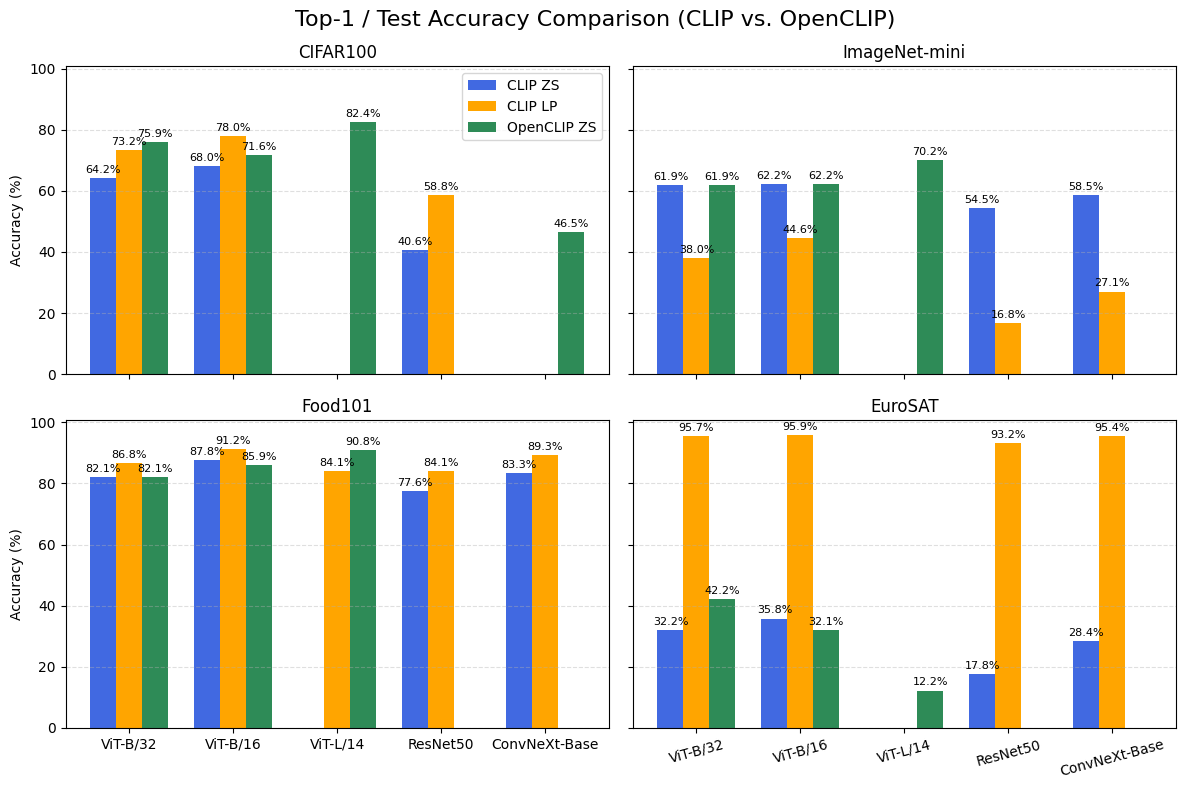

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# --- Your data (Top-1 only) ---
top1_data = {
    "CIFAR100": {
        "ViT-B/32":    [64.18, 73.20, 75.89],
        "ViT-B/16":    [68.04, 78.05, 71.61],
        "ViT-L/14":    [ 0.00,  0.00, 82.39],
        "ResNet50":    [40.62, 58.75,  0.00],
        "ConvNeXt-Base":[ 0.00,  0.00, 46.50],
    },
    "ImageNet-mini": {
        "ViT-B/32":    [61.89, 37.96, 61.89],
        "ViT-B/16":    [62.17, 44.59, 62.22],
        "ViT-L/14":    [ 0.00,  0.00, 70.20],
        "ResNet50":    [54.45, 16.82,  0.00],
        "ConvNeXt-Base":[58.49, 27.06,  0.00],
    },
    "Food101": {
        "ViT-B/32":    [82.06, 86.79, 82.10],
        "ViT-B/16":    [87.78, 91.19, 85.91],
        "ViT-L/14":    [ 0.00, 84.10, 90.78],
        "ResNet50":    [77.57, 84.10,  0.00],
        "ConvNeXt-Base":[83.28, 89.31,  0.00],
    },
    "EuroSAT": {
        "ViT-B/32":    [32.18, 95.65, 42.24],
        "ViT-B/16":    [35.80, 95.94, 32.12],
        "ViT-L/14":    [ 0.00,  0.00, 12.25],
        "ResNet50":    [17.75, 93.20,  0.00],
        "ConvNeXt-Base":[28.43, 95.36,  0.00],
    }
}

datasets = list(top1_data.keys())
models   = ["ViT-B/32", "ViT-B/16", "ViT-L/14", "ResNet50", "ConvNeXt-Base"]
methods  = ["CLIP ZS", "CLIP LP", "OpenCLIP ZS"]
colors   = ["royalblue", "orange", "seagreen"]
width    = 0.25  # bar group width

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

# If only one dataset, axes may not be an array:
if len(datasets) == 1:
    axes = [axes]

for ax, ds in zip(axes, datasets):
    x = np.arange(len(models))
    for i, method in enumerate(methods):
        # gather the i-th score for each model
        scores = [ top1_data[ds][m][i] for m in models ]
        ax.bar(x + (i-1)*width, scores, width, label=method, color=colors[i])
        # annotate
        for xi, score in zip(x + (i-1)*width, scores):
            if score>0:
                ax.text(xi, score+1, f"{score:.1f}%", ha="center", va="bottom", fontsize=8)

    ax.set_title(ds)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

# shared X labels
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(models, rotation=15)
axes[0].legend(loc="upper right")

# Shared ylabel and legend
axes[0].set_ylabel("Accuracy (%)")
axes[2].set_ylabel("Accuracy (%)")
axes[0].legend(loc="upper right")

plt.suptitle("Top-1 / Test Accuracy Comparison (CLIP vs. OpenCLIP)", fontsize=16)
plt.tight_layout()
plt.show()

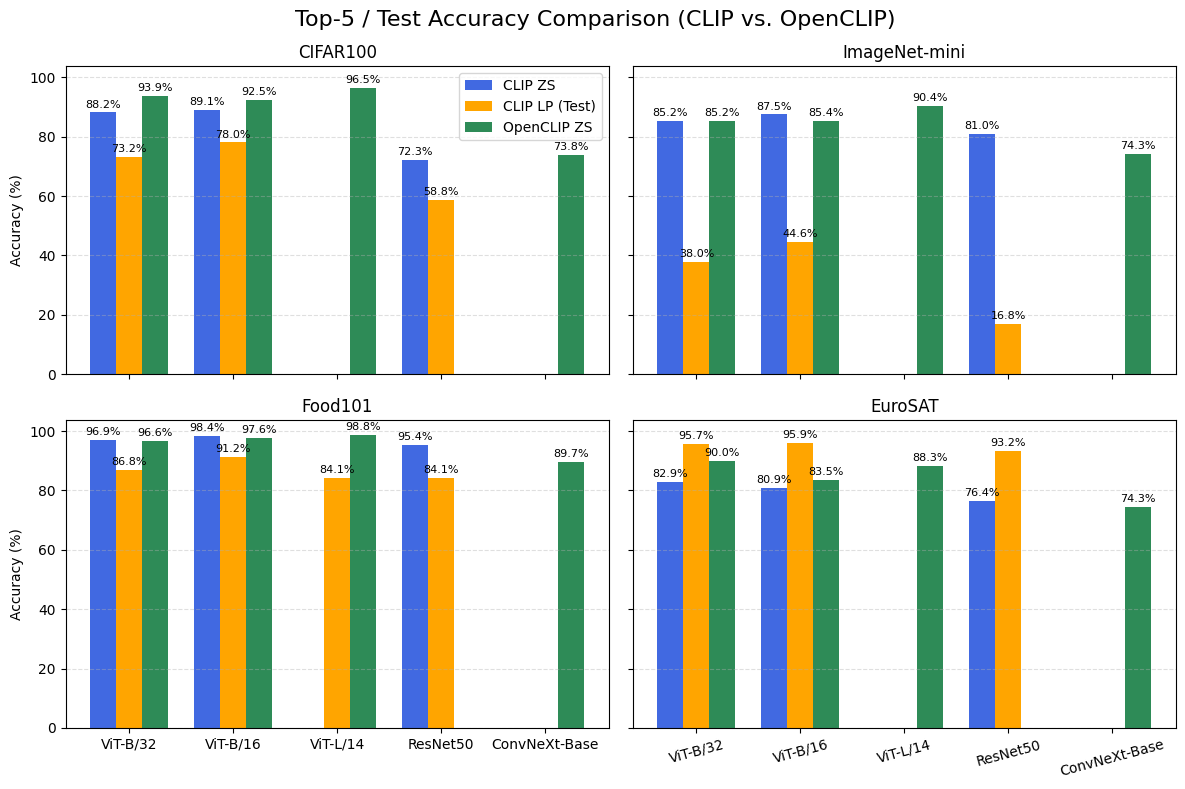

In [ ]:
# Correct Top-5 / test accuracies from your tables:
top5_data = {
    "CIFAR100": {
        "ViT-B/32":     [88.15, 73.20, 93.86],
        "ViT-B/16":     [89.14, 78.05, 92.47],
        "ViT-L/14":     [ 0.00,  0.00, 96.47],
        "ResNet50":     [72.30, 58.75,  0.00],
        "ConvNeXt-Base":[ 0.00,  0.00, 73.79],
    },
    "ImageNet-mini": {
        "ViT-B/32":     [85.24, 37.96, 85.24],
        "ViT-B/16":     [87.48, 44.59, 85.44],
        "ViT-L/14":     [ 0.00,  0.00, 90.39],
        "ResNet50":     [81.01, 16.82,  0.00],
        "ConvNeXt-Base":[ 0.00,  0.00, 74.28],
    },
    "Food101": {
        "ViT-B/32":     [96.89, 86.79, 96.62],
        "ViT-B/16":     [98.44, 91.19, 97.62],
        "ViT-L/14":     [ 0.00, 84.10, 98.76],
        "ResNet50":     [95.41, 84.10,  0.00],
        "ConvNeXt-Base":[ 0.00,  0.00, 89.68],
    },
    "EuroSAT": {
        "ViT-B/32":     [82.87, 95.65, 90.03],
        "ViT-B/16":     [80.89, 95.94, 83.49],
        "ViT-L/14":     [ 0.00,  0.00, 88.29],
        "ResNet50":     [76.40, 93.20,  0.00],
        "ConvNeXt-Base":[ 0.00,  0.00, 74.33],
    }
}

datasets = list(top5_data.keys())
models   = ["ViT-B/32", "ViT-B/16", "ViT-L/14", "ResNet50", "ConvNeXt-Base"]
methods  = ["CLIP ZS", "CLIP LP (Test)", "OpenCLIP ZS"]
colors   = ["royalblue", "orange", "seagreen"]
width    = 0.25

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, ds in zip(axes, datasets):
    x = np.arange(len(models))
    for i, method in enumerate(methods):
        scores = [top5_data[ds][m][i] for m in models]
        ax.bar(x + (i-1)*width, scores, width, label=method if ax is axes[0] else "", color=colors[i])
        for xi, sc in zip(x + (i-1)*width, scores):
            if sc > 0:
                ax.text(xi, sc + 1, f"{sc:.1f}%", ha="center", va="bottom", fontsize=8)

    ax.set_title(ds)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

# shared X labels
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(models, rotation=15)
axes[0].legend(loc="upper right")

# Shared ylabel and legend
axes[0].set_ylabel("Accuracy (%)")
axes[2].set_ylabel("Accuracy (%)")
axes[0].legend(loc="upper right")

plt.suptitle("Top-5 / Test Accuracy Comparison (CLIP vs. OpenCLIP)", fontsize=16)
plt.tight_layout()
plt.show()

# Text-to-Image Retrival

### Zero-shot

In [ ]:
import os
import clip
import torch
from torchvision.datasets import CIFAR10

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar10 = CIFAR10(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image, class_id = cifar10[3637]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar10.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar10.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

             cat: 79.23%
             dog: 9.81%
            bird: 3.71%
           horse: 3.17%
            deer: 2.44%


In [ ]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load('ViT-B/32', device=device)

cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

image, class_id = cifar100[3637]

image_input = preprocess(image).unsqueeze(0).to(device)

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

values, indices = similarity[0].topk(5)

print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")



Top predictions:

           snake: 65.31%
          turtle: 12.29%
    sweet_pepper: 3.83%
          lizard: 1.88%
       crocodile: 1.75%


In [ ]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image, class_id = cifar100[3637]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

           snake: 65.31%
          turtle: 12.29%
    sweet_pepper: 3.83%
          lizard: 1.88%
       crocodile: 1.75%


In [ ]:
import torch
import clip
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

# device
device = "cuda" if torch.cuda.is_available() else "cpu"

# CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

# token
text_inputs = clip.tokenize([f"a photo of a {c}" for c in class_names]).to(device)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=preprocess)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    text_features = model.encode_text(text_inputs)

    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        image_features = model.encode_image(images)

        logits_per_image = image_features @ text_features.T
        probs = logits_per_image.softmax(dim=-1)

        predicted = probs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Zero-shot CLIP accuracy on CIFAR-10 test set: {correct / total * 100:.2f}%")


Zero-shot CLIP accuracy on CIFAR-10 test set: 79.99%


Linear-probe evaluation

In [ ]:
import os
import clip
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load('ViT-B/32', device=device)

root = os.path.expanduser("~/.cache")
train_dataset = CIFAR100(root, download=True, train=True, transform=preprocess)
test_dataset = CIFAR100(root, download=True, train=False, transform=preprocess)

def get_features(dataset):
    all_features = []
    all_labels = []

    data_loader = DataLoader(dataset, batch_size=100, shuffle=False)

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device)
            features = model.encode_image(images)
            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

print("Extracting train features...")
train_features, train_labels = get_features(train_dataset)
print("Extracting test features...")
test_features, test_labels = get_features(test_dataset)

classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}%")


Extracting train features...


100%|██████████| 500/500 [2:00:26<00:00, 14.45s/it]  


Extracting test features...


100%|██████████| 100/100 [13:15<00:00,  7.96s/it]


Accuracy = 80.010%


In [ ]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 251MiB/s]
100%|██████████| 169M/169M [00:13<00:00, 12.8MB/s]
100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


Accuracy = 80.100


different prompt

In [ ]:
import os
import clip
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import CIFAR100, ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image


1. Promot

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device)
model.eval()


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [ ]:
from torchvision.datasets import EuroSAT
from torch.utils.data import DataLoader
import os

root = os.path.expanduser("~/.cache")
test_dataset = EuroSAT(root, download=True, transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
class_names = test_dataset.classes

print(f"EuroSAT class names: {class_names}")
print(f"Total test images: {len(test_dataset)}")


100%|██████████| 94.3M/94.3M [00:00<00:00, 282MB/s]


EuroSAT class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total test images: 27000


In [ ]:
# prompt_templates = [
#     "a photo of a {}",
#     "a picture of a {}",
#     "a blurry photo of a {}",
#     "a cropped photo of a {}",
# ]

prompt_templates = [
    "a photo of a {}",
    "a satellite photo of a {}",
    "an animal photo of a {}",
    "a sketch of a {}",
    "a drawing of a {}",
    "a cartoon of a {}",
    "a low-resolution photo of a {}"
]


In [ ]:
def evaluate_prompt(prompt_template):
    text_inputs = torch.cat([clip.tokenize(prompt_template.format(c)) for c in class_names]).to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        for images, labels in tqdm(test_loader, desc=f"Evaluating: '{prompt_template}'"):
            images = images.to(device)
            labels = labels.to(device)

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits = 100.0 * image_features @ text_features.T
            probs = logits.softmax(dim=-1)

            pred = probs.argmax(dim=-1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

    accuracy = 100.0 * correct / total
    return accuracy


In [ ]:
results = {}
for template in prompt_templates:
    acc = evaluate_prompt(template)
    results[template] = acc
    print(f"Prompt: '{template}' -> Accuracy: {acc:.2f}%")


Evaluating: 'a photo of a {}': 100%|██████████| 422/422 [00:54<00:00,  7.68it/s]


Prompt: 'a photo of a {}' -> Accuracy: 32.16%


Evaluating: 'a satellite photo of a {}': 100%|██████████| 422/422 [00:54<00:00,  7.75it/s]


Prompt: 'a satellite photo of a {}' -> Accuracy: 41.01%


Evaluating: 'an animal photo of a {}': 100%|██████████| 422/422 [00:54<00:00,  7.72it/s]


Prompt: 'an animal photo of a {}' -> Accuracy: 35.22%


Evaluating: 'a sketch of a {}': 100%|██████████| 422/422 [00:54<00:00,  7.70it/s]


Prompt: 'a sketch of a {}' -> Accuracy: 32.88%


Evaluating: 'a drawing of a {}': 100%|██████████| 422/422 [00:54<00:00,  7.74it/s]


Prompt: 'a drawing of a {}' -> Accuracy: 33.69%


Evaluating: 'a cartoon of a {}': 100%|██████████| 422/422 [00:54<00:00,  7.74it/s]


Prompt: 'a cartoon of a {}' -> Accuracy: 32.99%


Evaluating: 'a low-resolution photo of a {}': 100%|██████████| 422/422 [00:54<00:00,  7.75it/s]

Prompt: 'a low-resolution photo of a {}' -> Accuracy: 36.77%


Visualization

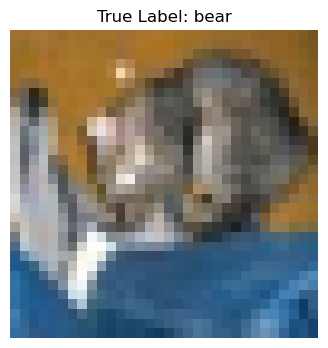

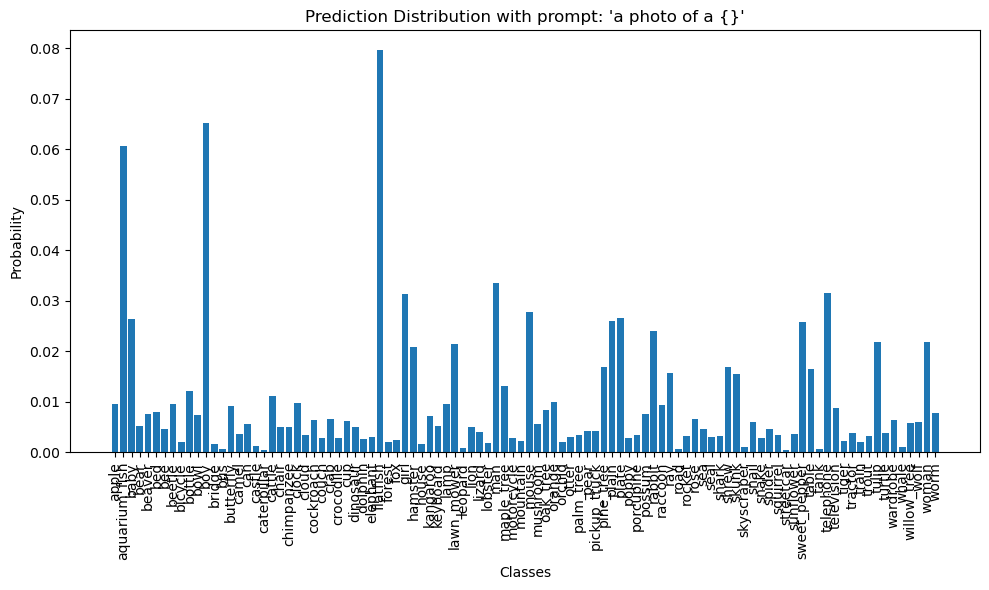

In [ ]:
def visualize_sample(prompt_template, sample_index=0):
    raw_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=None)
    image, true_label = raw_dataset[sample_index]

    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.title(f"True Label: {class_names[true_label]}")
    plt.axis("off")
    plt.show()

    image_input = preprocess(image).unsqueeze(0).to(device)

    text_inputs = torch.cat([clip.tokenize(prompt_template.format(c)) for c in class_names]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logits = 100.0 * image_features @ text_features.T
        probs = logits.softmax(dim=-1).cpu().numpy()[0]

    plt.figure(figsize=(10,6))
    plt.bar(range(len(class_names)), probs)
    plt.xticks(range(len(class_names)), class_names, rotation=90)
    plt.xlabel("Classes")
    plt.ylabel("Probability")
    plt.title(f"Prediction Distribution with prompt: '{prompt_template}'")
    plt.tight_layout()
    plt.show()

visualize_sample(prompt_templates[0], sample_index=0)


CIFAR-10

In [ ]:
import torchvision
from torch.utils.data import DataLoader
import torch
import clip
from tqdm import tqdm

class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=preprocess)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

prompt_templates = [
    "a photo of a {}",
    "a sketch of a {}",
    "a drawing of a {}",
    "a cartoon of a {}",
    "an artistic rendering of a {}",
    "a low-resolution photo of a {}"
]

def evaluate_prompt(prompt_template):
    text_inputs = torch.cat([clip.tokenize(prompt_template.format(c)) for c in class_names]).to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        for images, labels in tqdm(test_loader, desc=f"Evaluating: '{prompt_template}'"):
            images = images.to(device)
            labels = labels.to(device)

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits = 100.0 * image_features @ text_features.T
            probs = logits.softmax(dim=-1)

            pred = probs.argmax(dim=-1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

    accuracy = 100.0 * correct / total
    return accuracy

for template in prompt_templates:
    acc = evaluate_prompt(template)
    print(f"Prompt: '{template}' -> Accuracy: {acc:.2f}%")


Evaluating: 'a photo of a {}': 100%|██████████| 157/157 [13:16<00:00,  5.07s/it]


Prompt: 'a photo of a {}' -> Accuracy: 88.80%


Evaluating: 'a sketch of a {}': 100%|██████████| 157/157 [12:31<00:00,  4.79s/it]


Prompt: 'a sketch of a {}' -> Accuracy: 87.93%


Evaluating: 'a drawing of a {}': 100%|██████████| 157/157 [12:58<00:00,  4.96s/it]


Prompt: 'a drawing of a {}' -> Accuracy: 89.31%


Evaluating: 'a cartoon of a {}': 100%|██████████| 157/157 [12:56<00:00,  4.94s/it]


Prompt: 'a cartoon of a {}' -> Accuracy: 89.70%


Evaluating: 'an artistic rendering of a {}': 100%|██████████| 157/157 [12:58<00:00,  4.96s/it]


Prompt: 'an artistic rendering of a {}' -> Accuracy: 89.73%


Evaluating: 'a low-resolution photo of a {}': 100%|██████████| 157/157 [12:56<00:00,  4.95s/it]

Prompt: 'a low-resolution photo of a {}' -> Accuracy: 89.07%


In [ ]:
no_prompt_template = "{}"
no_prompt_accuracy = evaluate_prompt(no_prompt_template)
print(f"No prompt (only category name) -> Accuracy: {no_prompt_accuracy:.2f}%")


Evaluating: '{}': 100%|██████████| 157/157 [12:58<00:00,  4.96s/it]

No prompt (only category name) -> Accuracy: 87.35%


In [ ]:
import torchvision
from torch.utils.data import DataLoader
import torch
import clip
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=preprocess)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

prompt_templates = [
    "a photo of a {}",
    "a sketch of a {}",
    "a drawing of a {}",
    "a cartoon of a {}",
    "an artistic rendering of a {}",
    "a low-resolution photo of a {}"
]

def evaluate_prompt(prompt_template):
    text_inputs = torch.cat([clip.tokenize(prompt_template.format(c)) for c in class_names]).to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        for images, labels in tqdm(test_loader, desc=f"Evaluating: '{prompt_template}'"):
            images = images.to(device)
            labels = labels.to(device)

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits = 100.0 * image_features @ text_features.T
            probs = logits.softmax(dim=-1)

            pred = probs.argmax(dim=-1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

    accuracy = 100.0 * correct / total
    return accuracy

for template in prompt_templates:
    acc = evaluate_prompt(template)
    print(f"Prompt: '{template}' -> Accuracy: {acc:.2f}%")

no_prompt_template = "{}"
no_prompt_accuracy = evaluate_prompt(no_prompt_template)
print(f"No prompt (only category name) -> Accuracy: {no_prompt_accuracy:.2f}%")


Evaluating: 'a photo of a {}': 100%|██████████| 157/157 [13:02<00:00,  4.98s/it]


Prompt: 'a photo of a {}' -> Accuracy: 88.80%


Evaluating: 'a sketch of a {}': 100%|██████████| 157/157 [13:02<00:00,  4.98s/it]


Prompt: 'a sketch of a {}' -> Accuracy: 87.93%


Evaluating: 'a drawing of a {}': 100%|██████████| 157/157 [13:02<00:00,  4.98s/it]


Prompt: 'a drawing of a {}' -> Accuracy: 89.31%


Evaluating: 'a cartoon of a {}': 100%|██████████| 157/157 [13:04<00:00,  5.00s/it]


Prompt: 'a cartoon of a {}' -> Accuracy: 89.70%


Evaluating: 'an artistic rendering of a {}': 100%|██████████| 157/157 [13:02<00:00,  4.99s/it]


Prompt: 'an artistic rendering of a {}' -> Accuracy: 89.73%


Evaluating: 'a low-resolution photo of a {}': 100%|██████████| 157/157 [13:01<00:00,  4.98s/it]


Prompt: 'a low-resolution photo of a {}' -> Accuracy: 89.07%


Evaluating: '{}': 100%|██████████| 157/157 [13:01<00:00,  4.98s/it]

No prompt (only category name) -> Accuracy: 87.35%


find pic according to prompt

In [ ]:
import torch
import clip
import open_clip
from torchvision.datasets import CocoCaptions
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

model_openai, preprocess_openai = clip.load("ViT-B/32", device=device)
model_openclip, _, preprocess_openclip = open_clip.create_model_and_transforms(
    'ViT-B-32', pretrained='laion2b_e16'
)
model_openai.eval()
model_openclip.eval()

coco_root = 'D:/MDS/Block6/DATA 586 Advanced Machine Learning/project/data/coco'
coco = CocoCaptions(
    root=f"{coco_root}/val2017",
    annFile=f"{coco_root}/annotations/captions_val2017.json",
    transform=None
)

print(f"Photo number: {len(coco)}")


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
Photo number: 5000


In [ ]:
subset_size = 500
top_k = 10

def extract_features(model, preprocess, name):
    image_features_list = []
    image_list = []
    with torch.no_grad():
        for i in tqdm(range(subset_size), desc=f"Processing with {name}"):
            image, captions = coco[i]
            original_image = transforms.ToTensor()(image)
            processed_image = preprocess(image).unsqueeze(0).to(device)

            features = model.encode_image(processed_image)
            features /= features.norm(dim=-1, keepdim=True)

            image_features_list.append(features.cpu())
            image_list.append((original_image, captions, preprocess(image)))

    return torch.cat(image_features_list, dim=0), image_list

features_openai, images_openai = extract_features(model_openai, preprocess_openai, "OpenAI CLIP")
features_openclip, images_openclip = extract_features(model_openclip, preprocess_openclip, "OpenCLIP")


Processing with OpenCLIP: 100%|██████████| 500/500 [01:18<00:00,  6.34it/s]


In [ ]:
text_input = input("Input description:")

with torch.no_grad():
    text_tokens_openai = clip.tokenize([text_input]).to(device)
    text_feature_openai = model_openai.encode_text(text_tokens_openai)
    text_feature_openai /= text_feature_openai.norm(dim=-1, keepdim=True)

    text_tokens_openclip = open_clip.tokenize([text_input]).to(device)
    text_feature_openclip = model_openclip.encode_text(text_tokens_openclip)
    text_feature_openclip /= text_feature_openclip.norm(dim=-1, keepdim=True)

sim_openai = (text_feature_openai @ features_openai.T).squeeze(0)
sim_openclip = (text_feature_openclip @ features_openclip.T).squeeze(0)

topk_openai = sim_openai.topk(top_k).indices
topk_openclip = sim_openclip.topk(top_k).indices

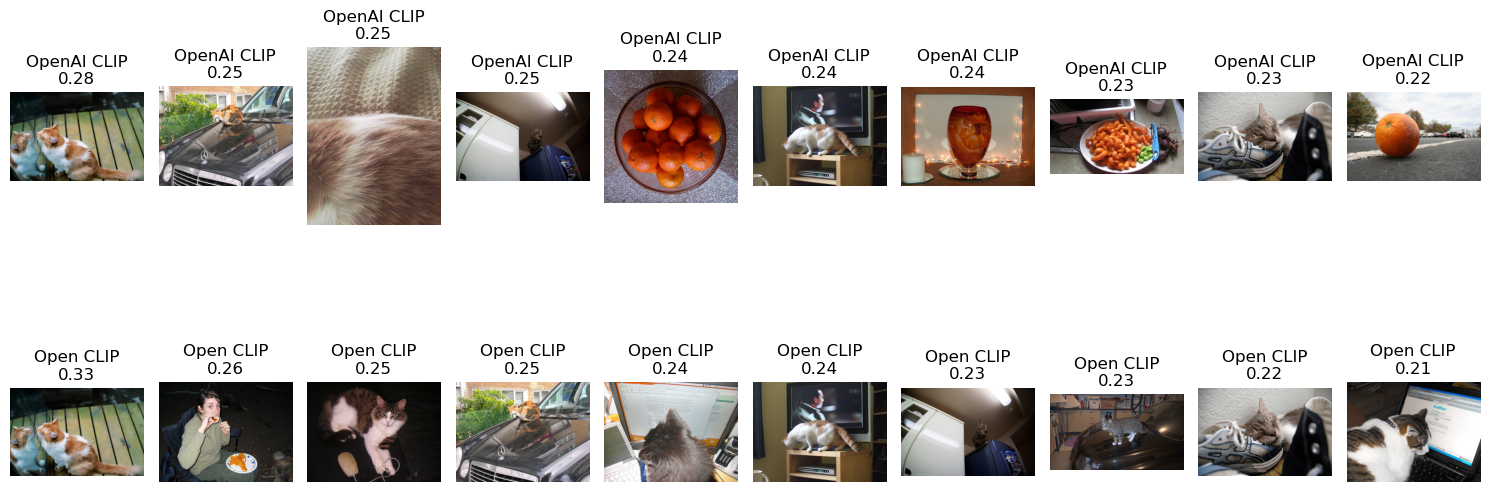

In [ ]:
plt.figure(figsize=(15, 12))
rows = [
    ("OpenAI CLIP", images_openai, sim_openai, False),
    ("Open CLIP", images_openclip, sim_openclip, False)
]

for row_idx, (title, image_list, similarity, is_processed) in enumerate(rows):
    for i, idx in enumerate(topk_openai if "OpenAI" in title else topk_openclip):
        img_tensor, caption, processed = image_list[idx]
        img = processed if is_processed else img_tensor
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display

        plt.subplot(4, top_k, row_idx * top_k + i + 1)
        plt.imshow(img)
        plt.title(f"{title}\n{similarity[idx]:.2f}")
        plt.axis("off")

plt.tight_layout()
plt.show()

ImageNet

In [ ]:
import torch
import clip
import open_clip
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

model_openai, preprocess_openai = clip.load("ViT-B/32", device=device)
model_openclip, _, preprocess_openclip = open_clip.create_model_and_transforms(
    'ViT-B-32', pretrained='laion2b_e16'
)
model_openai.eval()
model_openclip.eval()

imagenet_root = "D:/MDS/Block6/DATA 586 Advanced Machine Learning/project/data/archive/imagenet-mini"
val_dataset = ImageFolder(root=os.path.join(imagenet_root, "val"))


In [ ]:
subset_size = min(500, len(val_dataset))
top_k = 10

def extract_features(model, preprocess, name):
    image_features_list = []
    image_list = []
    with torch.no_grad():
        for i in tqdm(range(subset_size), desc=f"Processing {name}"):
            pil_image, label = val_dataset[i]
            original_image = transforms.ToTensor()(pil_image)
            processed_image = preprocess(pil_image).unsqueeze(0).to(device)

            features = model.encode_image(processed_image)
            features /= features.norm(dim=-1, keepdim=True)

            image_features_list.append(features.cpu())
            image_list.append((original_image, val_dataset.classes[label], preprocess(pil_image)))

    return torch.cat(image_features_list, dim=0), image_list

features_openai, images_openai = extract_features(model_openai, preprocess_openai, "OpenAI CLIP")
features_openclip, images_openclip = extract_features(model_openclip, preprocess_openclip, "OpenCLIP")


Processing OpenCLIP: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s]


In [ ]:
text_input = input("Input description:")

with torch.no_grad():
    text_tokens_openai = clip.tokenize([text_input]).to(device)
    text_feature_openai = model_openai.encode_text(text_tokens_openai)
    text_feature_openai /= text_feature_openai.norm(dim=-1, keepdim=True)

    text_tokens_openclip = open_clip.tokenize([text_input]).to(device)
    text_feature_openclip = model_openclip.encode_text(text_tokens_openclip)
    text_feature_openclip /= text_feature_openclip.norm(dim=-1, keepdim=True)

sim_openai = (text_feature_openai @ features_openai.T).squeeze(0)
sim_openclip = (text_feature_openclip @ features_openclip.T).squeeze(0)

topk_openai = sim_openai.topk(top_k).indices
topk_openclip = sim_openclip.topk(top_k).indices


In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

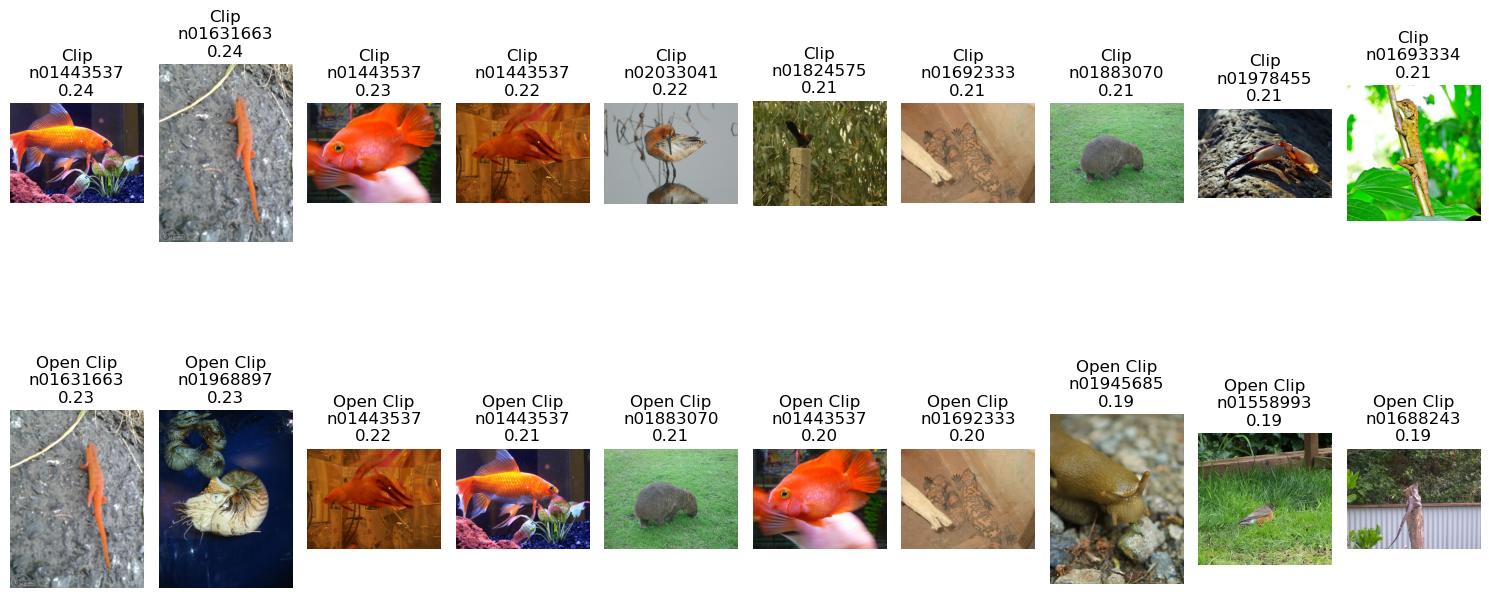

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(top_k):
    img_ai, label_ai, _ = images_openai[topk_openai[i]]
    plt.subplot(2, top_k, i + 1)
    plt.imshow(img_ai.permute(1, 2, 0))
    plt.title(f"Clip\n{label_ai}\n{sim_openai[topk_openai[i]]:.2f}")
    plt.axis("off")

    img_oc, label_oc, _ = images_openclip[topk_openclip[i]]
    plt.subplot(2, top_k, top_k + i + 1)
    plt.imshow(img_oc.permute(1, 2, 0))
    plt.title(f"Open Clip\n{label_oc}\n{sim_openclip[topk_openclip[i]]:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()
